In [1]:
from IPython.display import Image
from fable_functions import *
from circuit_files import *
import numpy as np
import scipy as sp
import random
import cirq

/home/test/ocean/lib/python3.6/site-packages/google/auth/crypt/_cryptography_rsa.py:22: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography. The next release of cryptography will remove support for Python 3.6.
  import cryptography.exceptions


# LS-FABLE: A fast approximate block-encoding for sparse matrices



In this document we examine a modification of the existing FABLE algorithm and demonstrate its comparative advantage for block-encoding sparse matrices.

## Overview of FABLE (Fast Approximate BLock-Encoding)

FABLE is a block-encoding algorithm which can block-encode an arbitrary dense matrix into a quantum circuit. Recall that a the unitary matrix $U$ is a $(\alpha ,m,\epsilon )$ block-encoding of a matrix $A$ if $\lVert A-\tilde{A}\rVert <\epsilon$ where $\tilde{A}$ satisfies
$$\tilde{A}=\left(\langle 0|^{\otimes m}\otimes I_n\right) U\left( |0\rangle ^{\otimes m}\otimes I_n\right)$$
In the FABLE block encoding scheme for an $n$ qubit matrix $A$ with real entries $a_{ij}\in [-1,1]$ ($A$ is $N\times N$ where $N=2^n$), we first assume the existence of an oracle $O_A$ which has the following action:
$$O_A|0\rangle |i\rangle |j\rangle =a_{ij}|0\rangle |i\rangle |j\rangle +\sqrt{1-a_{ij}}|1\rangle |i\rangle |j\rangle$$
Given this oracle, one can show that the following circuit is a $(1/2^n,n+1,0)$ block encoding of $A$.

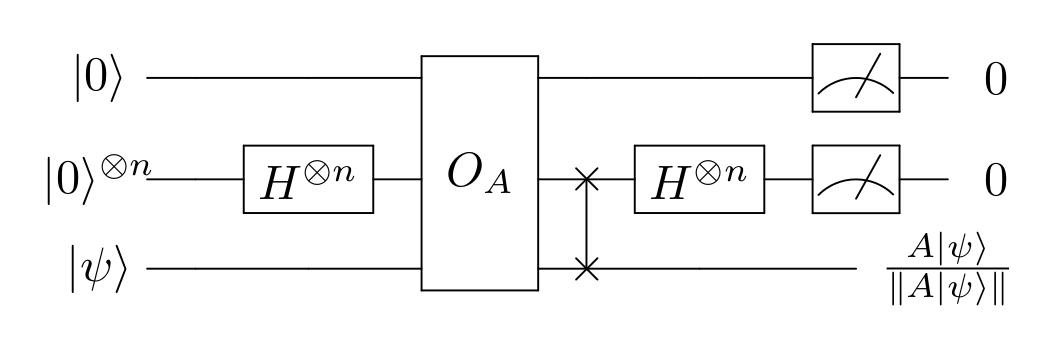

In [5]:
Image("fig1.png")

It remains to efficiently construct the oracle $O_A$. While one could na\"{i}vely build the oracle by defining angles $\theta _{ij}=\cos^{-1}(a_{ij})$ and putting $N^2$ multi-qubit controlled rotations in sequence, these operations are expensive and require $O(N^4)$ one and two-qubit gates to implement. Instead, we can exploit Gray code to reduce the cost down to exactly $N^2$ $R_y$ rotations and $N^2$ CNOT gates. Let $\theta$ be the vector of angles $\theta _{ij}$ arranged by columns, let $P_G$ be the permutation matrix transforming binary into Gray code, and let $g_j$ be the bit flip between the $j^\text{th}$ and $(j-1)^\text{th}$ Gray code numbers. Then we can define $O_A$ as alternating $R_y(\hat{\theta}_k)$ on the $0^\text{th}$ qubit and CNOT with target on the $0^\text{th}$ qubit and control on the $2n-g_j$ qubit; instead of using $\theta$ in the rotation gates we use a transformed set of angles which satisfy $NP_GH^{\otimes 2n}\hat{\theta }=\theta$. The picture below shows an example oracle for a $1$-qubit matrix:

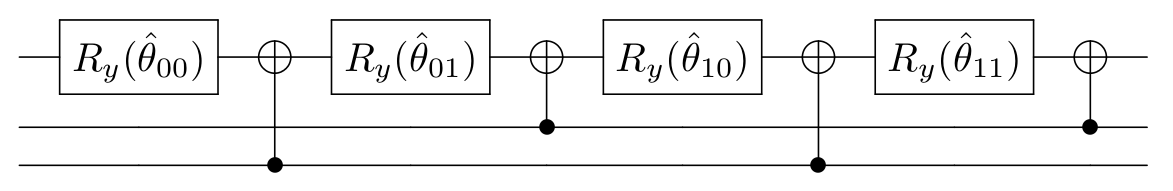

In [6]:
Image("fig2.png")

The advantage of this scheme is that for certain matrices, the oracle can be compressed at little cost to the accuracy of the encoding. If any of the $\hat{\theta}$ are smaller than some threshold value, we can remove them from the circuit. Then since the resulting sequence of CNOT gates between significant rotations all have the same target, they can commute and potentially cancel. The figure below demonstrates an example of the oracle being compressed; what starts as a 16 gate circuit reduces to 7 total gates in this case.

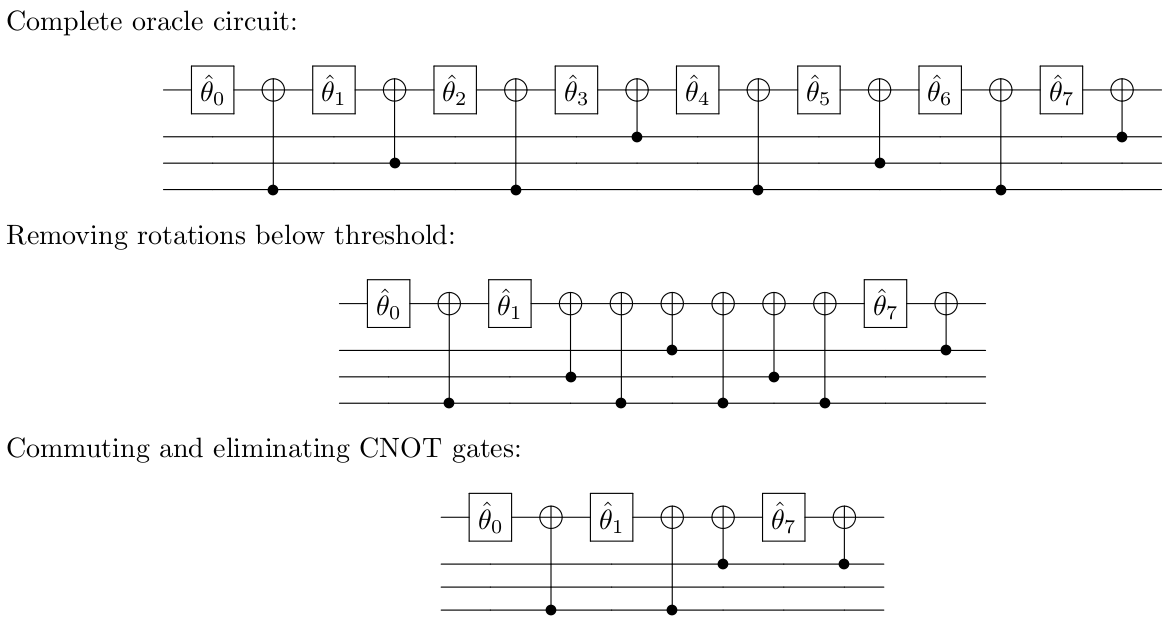

In [8]:
Image("fig3.png")

The question naturally arises, is there a class of matrices $A$ which lend themselves to highly compressible FABLE oracles? Though the transformation from matrix entries in $A$ to angles used in the rotation gates $\hat{\theta}$ is nonlinear, we find that matrices sparse in the Hadamard-Walsh domain (i.e. $H^{\otimes n}AH^{\otimes n}$ is sparse) tend to have oracles that compress well.

## S-FABLE: A modification of FABLE for sparse matrices

Rather than searching for a precise class of matrices which compress well under FABLE block-encodings, we consider the converse; can we \emph{transform} a pertinent class of matrices into a different class with better compression properties? We answer this question in the affirmative by documenting S-FABLE (sparse-FABLE). If $A$ is a sparse matrix, then in general $HAH$ is dense and thus the oracle $O_A$ requires most of its gates to block-encode to reasonable accuracy. However, if $A$ is sparse, then the matrix $HAH$ has a highly compressible FABLE oracle (since $H(HAH)H=A$ is sparse). Therefore if we use a FABLE circuit to block-encode $HAH$, we can conjugate the circuit with multi-qubit 0-controlled Hadamard gates to recover a block encoding of $A$, depicted below:

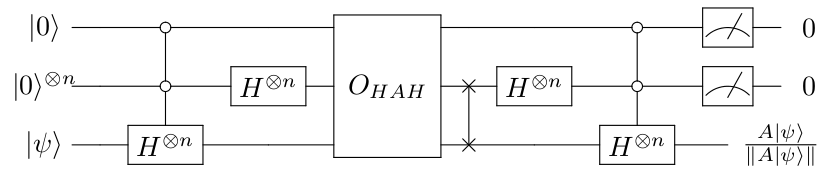

In [9]:
Image("fig4.png")

The additional costs incurred by using this S-FABLE circuit are classically computing the Hadamard conjugation $HAH$ (an extra $O(N^2\log N)$ operations on top of the $O(N^2\log N)$ needed in FABLE) as well as an extra $O(N\log N)$ one and two-qubit quantum gates to implement the controlled-H operators. At these modest costs, we benefit from a highly compressed oracle $O_{HAH}$. The table below compares the gate counts of implementing both FABLE and S-FABLE for a 13-qubit matrix $A$ with an average of 12 nonzero entries per row/column and an $L^2$ norm difference in approximation of $\epsilon =2^{-10}$. Notice that in this case S-FABLE uses less than 2\% of the gates that FABLE uses to achieve the same accuracy in approximation

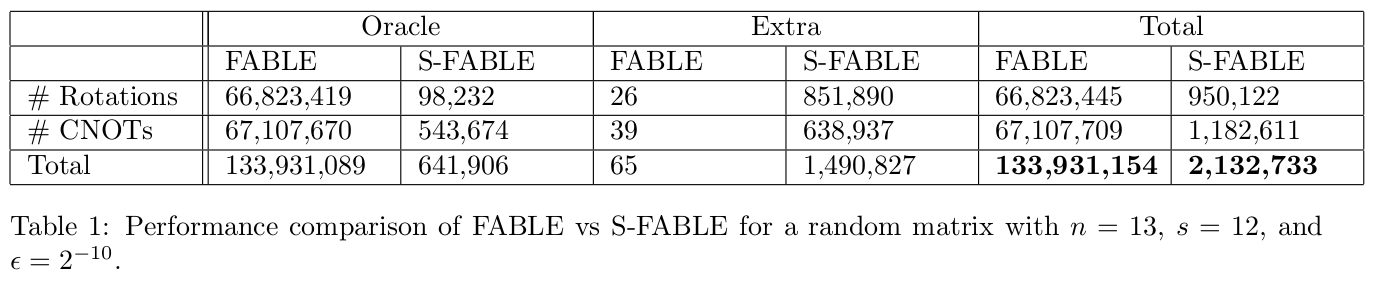

In [10]:
Image("fig5.png")

## LS-FABLE: Eliminating classical overhead from S-FABLE

While the S-FABLE oracle is highly compressible compared to the FABLE oracle for sparse matrices, the classical costs of $O(N^2\log N)$ operations will quickly get out of hand for large matrices. Fortunately, it is possible to layer a further approximation on top of S-FABLE to eliminate these quadratic classical costs; what follows is a description of the LS-FABLE (lazy sparse-FABLE) method. Using a Taylor series approximation $\cos ^{-1}(x)=\frac{\pi}{2}-x$, we define the matrix of transformed rotation angles in the S=FABLE circuit as $\hat{\theta}=\frac{\pi}{2}E_{1,1}-\frac{1}{N}A$ where $E_{1,1}$ the empty matrix with a single 1 entry in the top left corner. Because a scaled copy of $A$ is used in the rotation gates, there are exactly as many rotation gates in the oracle as there are nonzero entries in $A$; the more sparse $A$ is the more we can compress the oracle. When $\hat{\theta}$ is substituted into the rotation gates, the matrix being block-encoded is not $A$ but instead precisely $H\sin(HAH)H$ where $\sin$ is taken to be entrywise. When $A$ is sparse, this matrix sufficiently well approximates $A$ in the $L^2$ norm, and this approximation only improves as the size of $A$ increases. If $A$ is an $n$-qubit sparse matrix with on average $s$ nonzero entries per row/column and each of those entries are uniformly distributed between $[-1,1]$, then we observe the following error in the block-encoding
$$\lVert A-H\sin(HAH)H\rVert\approx 0.2969\cdot\frac{s^{1.6709}}{N^{1.0191}}$$
To reiterate, the advantage of LS-FABLE over S-FABLE is that the only classical computations involved are dividing each of the nonzero entries by $N$; if there are $O(N)$ nonzero entries in the matrix (i.e. $O(1)$ average number of nonzero entries per row/column) then there are $O(N)$ classical operations in LS-FABLE compared to $O(N^2\log N)$ in S-FABLE. Furthermore, the number of one and two-qubit gates used in LS-FABLE are $O(N\log N)$, while the error in the approximation exponentially decreases as the number of qubits increases.

## Code example

In this section we illustrate the construction of a LS-FABLE circuit for block-encoding a $4\times 4$ sparse matrix. First, we generate the matrix in a sparse format.

In [11]:
n = 2                            #size of matrix (2^n x 2^n entries)
N = 2**n                         #single dimension of matrix
s = 1                            #number of nonzero entries per row/column
[i1,i2,v] = gen_sparse(n,s)      #generate sparse matrix in sparse format [row,column,value]
A = sparse_to_mat(i1,i2,v,2**n)  #convert sparse format into matrix array
print(A)

[[ 0.82601837  0.          0.          0.        ]
 [ 0.          0.56348701  0.         -0.55301582]
 [ 0.          0.          0.          0.73223522]
 [ 0.          0.          0.          0.        ]]


Without compiling a circuit, we can precisely compute how well LS-FABLE will approximate a matrix $A$ using the formula above:

In [12]:
A1 = ls_block(A) #compute the exact matrix LS-FABLE will block encode (i.e. Hsin(HAH)H)
e = l2norm(A-A1) #calculate L2 norm error of LS-FABLE calculation
print('L2 norm error: ' +str(e))

L2 norm error: 0.05245214959799744


We compile the LS-FABLE oracle for the matrix $A$. To do this, we build a `struc` vector of integers which encodes the structure of the oracle; a 0 corresponds to a rotation gate and anything greater corresponds to a CNOT with control on the denoted qubit. The standard `struc` vector only depends on the size of the matrix, but we can compress it depending on the location of nonzero entries in the matrix $A$:

In [13]:
I = two_to_one_index(i2,i1,N)          #convert (i,j) indexing of matrix to a single number
[I1,v1] = convert_mat_to_gray(I,v,n)   #convert sparse representation into the correct Gray code ordering
struc = cnot_base_structure(I1,n)      #build the CNOT structure of the oracle given locations of nonzero entries
print(struc)

[0, 1, 2, 3, 0, 2, 0, 2, 3, 4, 0, 1, 2, 4]


Once this structure is established, we can plug scaled copies of the nonzero entries of $A$ into the correct rotation slots with Gray code ordering. We can now display the oracle circuit:

In [14]:
oracle = LS_orace_from_sparse(i2,i1,v,n) #build the LS-FABLE oracle
print(oracle)

0: ───Ry(π)───Ry(-0.131π)───X───X───X───Ry(0.088π)───X───Ry(-0.09π)───X───X───X───Ry(-0.117π)───X───X───X───
                            │   │   │                │                │   │   │                 │   │   │
1: ─────────────────────────┼───┼───┼────────────────┼────────────────┼───┼───@─────────────────┼───┼───@───
                            │   │   │                │                │   │                     │   │
2: ─────────────────────────┼───┼───@────────────────┼────────────────┼───@─────────────────────┼───┼───────
                            │   │                    │                │                         │   │
3: ─────────────────────────┼───@────────────────────@────────────────@─────────────────────────┼───@───────
                            │                                                                   │
4: ─────────────────────────@───────────────────────────────────────────────────────────────────@───────────


Now that the oracle is established, all that remains is to surround the oracle with the extra FABLE and S-FABLE circuits to complete the block-encoding. We check that this circuit is doing what we expect.

In [15]:
fable_circ = oracle_surround(oracle,n)       #surround the oracle with the other FABLE gates to block encode sin(HAH)
final_circ = sparse_surround(fable_circ,n)   #surround the FABLE circuit with controlled H gates to block encode Hsin(HAH)H
print(final_circ)

#test that the block encoding is doing what we expect (error should be close to machine precision)
A2 = cirq.unitary(final_circ)                
A2 = np.real(A2)
A3 = (2**n) * A2[0:2**n,0:2**n]
e1 = l2norm(A1-A3)
print('L2 norm error: ' +str(e1))

                                                                                                                                ┌──┐
0: ───X───@───@───X───────Ry(π)───Ry(-0.131π)───X───X───X───Ry(0.088π)───X───Ry(-0.09π)───X───X───X───Ry(-0.117π)───X───X───X──────────────X───@───@───X───
          │   │                                 │   │   │                │                │   │   │                 │   │   │                  │   │
1: ───X───@───@───X───H─────────────────────────┼───┼───┼────────────────┼────────────────┼───┼───@─────────────────┼───┼───@────×─────H───X───@───@───X───
          │   │                                 │   │   │                │                │   │                     │   │        │             │   │
2: ───X───@───@───X───H─────────────────────────┼───┼───@────────────────┼────────────────┼───@─────────────────────┼───┼────────┼×────H───X───@───@───X───
          │   │                                 │   │                    │                │          

Now that we have illustrated the LS-FABLE method for a small block-encoding, we combine this procedure in a single function to output a circuit for a larger block-encoding:

In [16]:
n = 7                                   #size of matrix (2^n x 2^n entries)
N = 2**n                                #single dimension of matrix
s = 1                                   #number of nonzero entries per row/column
[i1,i2,v] = gen_sparse(n,s)             #generate sparse matrix in sparse format [row,column,value]
ls_circuit = LS_FALBE_full(i1,i2,v,n)   #generate LS-FABLE block-encoding circuit

A = sparse_to_mat(i1,i2,v,2**n)          #convert sparse format into matrix array
A1 = ls_block(A)                         #compute the exact matrix LS-FABLE will block encode (i.e. Hsin(HAH)H)
e2 = l2norm(A-A1)                        #calculate L2 norm error of LS-FABLE calculation
print('L2 norm error: ' +str(e2))
print(ls_circuit)

L2 norm error: 0.0023327143321835828
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

## Caveats

While S-FABLE and LS-FABLE show promise, they do not compress well for all sparse matrices. In particular, they perform poorly if the matrices to be block-encoded are nonnegative or otherwise demonstrate symmetry. As the matrices become more disordered (e.x. random sparse matrices with nonzero entries randomly distributed from $[-1,1]$), the comparative advantage of LS-FABLE and S-FABLE over FABLE increases.